In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar, ModelCheckpoint
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassConfusionMatrix
from torch.optim import Adam
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

from pathlib import Path
import os
import nltk
from nltk.corpus import stopwords
from typing import Literal, Callable, Any
import re
from functools import partial

from torch import Tensor
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS

import seaborn as sns

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)

from torchmetrics.classification import (
    MulticlassPrecision,
    MulticlassRecall,
)

In [2]:
RANDOM_SEED = 123
pl.seed_everything(RANDOM_SEED)

Global seed set to 123


123

In [3]:
device = torch.device("cuda")
torch.set_float32_matmul_precision("high")

In [4]:
df_train = pd.read_csv("data/train_data.csv")
df_train

,review,rating
0,location not palace excellent hotel booke dthe...,4
1,respite definitely not place stay looking ultr...,3
2,stunning truly memorable spot right beach nusa...,4
3,solid business hotel near embassy stayed hotel...,3
4,nice place make sure lock money warning money ...,3
...,...,...
16387,great base explore new york stayed 4 nights en...,4
16388,wonderful advert paris wonderful introduction ...,4
16389,ideal relaxing holdiay rachel jay green liverp...,3
16390,"watch food, husband went resort 4 nights chris...",2


## 1. Klasyfikacja na podstawie reprezentacji TFIDF

Szybkie przeuczenie nawet po dodaniu regularyzacji i ważenia klas w funkcji straty, bardzo słabe wyniki

In [5]:
class_counts = df_train.groupby("rating").count()
class_counts

,review
rating,
0,1137
1,1434
2,1747
3,4831
4,7243


In [6]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.review, df_train.rating, test_size=0.2, random_state=42
)

In [7]:
class TFIDFClassifier(nn.Module):
    def __init__(self):
        super(TFIDFClassifier, self).__init__()
        self.lin1 = nn.Linear(10000, 4000)
        self.act1 = nn.LeakyReLU()
        self.lin2 = nn.Linear(4000, 1000)
        self.act2 = nn.LeakyReLU()
        self.lin3 = nn.Linear(1000, 500)
        self.act3 = nn.LeakyReLU()
        self.lin4 = nn.Linear(500, 50)
        self.act4 = nn.LeakyReLU()
        self.lin5 = nn.Linear(50, 5)

    def forward(self, x):
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)
        x = self.lin3(x)
        x = self.act3(x)
        x = self.lin4(x)
        x = self.act4(x)
        x = self.lin5(x)
        return x


tfidf_model = TFIDFClassifier().to(device)
tfidf_model

TFIDFClassifier(
  (lin1): Linear(in_features=10000, out_features=4000, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (lin2): Linear(in_features=4000, out_features=1000, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (lin3): Linear(in_features=1000, out_features=500, bias=True)
  (act3): LeakyReLU(negative_slope=0.01)
  (lin4): Linear(in_features=500, out_features=50, bias=True)
  (act4): LeakyReLU(negative_slope=0.01)
  (lin5): Linear(in_features=50, out_features=5, bias=True)
)

In [8]:
count_vectorizer_train = CountVectorizer()
x_vectorized_train = count_vectorizer_train.fit_transform(x_train.values)
tfidf_transformer_train = TfidfTransformer()
x_transformed_train = tfidf_transformer_train.fit_transform(x_vectorized_train)[
    :, :10000
]

count_vectorizer_val = CountVectorizer()
x_vectorized_val = count_vectorizer_val.fit_transform(x_val.values)
tfidf_transformer_val = TfidfTransformer()
x_transformed_val = tfidf_transformer_val.fit_transform(x_vectorized_val)[:, :10000]

In [9]:
train_dataset = TensorDataset(
    torch.from_numpy(x_transformed_train.todense()).to(torch.float),
    torch.tensor(y_train.values),
)
val_dataset = TensorDataset(
    torch.from_numpy(x_transformed_val.todense()).to(torch.float),
    torch.tensor(y_val.values),
)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [11]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval()  # *********#
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]  # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [12]:
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor(1 / class_counts.values).squeeze().to(torch.float).to(device)
)
optimizer = Adam(tfidf_model.parameters(), lr=0.001, weight_decay=1e-3)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, labels in iter(train_loader):
        x, labels = x.to(device), labels.to(device)
        tfidf_model.train()
        out = tfidf_model(x).squeeze()

        loss = criterion(out, labels)
        loss.backward()
        epoch_losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(tfidf_model, val_loader)
    print(f"Epoch {n} loss {loss_mean:.3} val_acc: {test_acc:.3}")
    train_acc.append(
        get_accuracy(tfidf_model, train_loader)
    )  # compute training accuracy
    val_acc.append(test_acc)  # compute validation accuracy


print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))
print("Max Validation Accuracy: {}".format(max(val_acc)))

Epoch 0 loss 1.61 val_acc: 0.107
Epoch 1 loss 1.61 val_acc: 0.107
Epoch 2 loss 1.61 val_acc: 0.441
Epoch 3 loss 1.61 val_acc: 0.441
Epoch 4 loss 1.61 val_acc: 0.441
Epoch 5 loss 1.61 val_acc: 0.441
Epoch 6 loss 1.61 val_acc: 0.293
Epoch 7 loss 1.61 val_acc: 0.441
Epoch 8 loss 1.61 val_acc: 0.441
Epoch 9 loss 1.61 val_acc: 0.441
Final Training Accuracy: 0.44217218137254904
Final Validation Accuracy: 0.44129307715767
Max Validation Accuracy: 0.44129307715767


## 2. Klasyfikacja za pomocą modelu LLM

TODO wnioski

In [13]:
# TODO implement

## 3. Klasyfikacja za pomocą dostrojonego modelu BERT

Szybkie przeuczenie, ale na ogół dobre wyniki

Testowane modyfikacje:
- Mniejszy model - przeuczenie następuje wolniej, ale nie osiąga lepszych wyników
- Regularyzacja L2 - nie jest w stanie zapobiec przeuczeniu
- Regresja zamiast klasyfikacji - dużo wolniejsze przeuczenie, wyniki podobne bądź nieco gorsze
- Model RoBERTa - podobne wyniki
- Preferencje dla klas mniejszościowych w `DataLoader` - początkowo lepszy balans accuracy między klasami, ale w późnych epokach zawsze dąży rozkładu

In [14]:
Path_t = str | bytes | os.PathLike

In [15]:
TRAIN_PATH = Path("./data/train_data.csv")
NLTK_DIR = Path("./nltk")
MODEL_DIR = Path("./models")

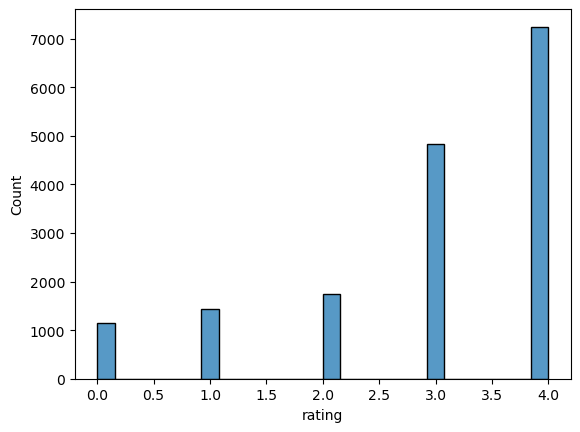

In [16]:
df_raw = pd.read_csv(TRAIN_PATH)
sns.histplot(df_raw["rating"])
cls_counts = np.histogram(df_raw["rating"], bins=5)[0]

In [31]:
class TextClassificationDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_path: Path_t,
        tokenizer: BertTokenizer,
        batch_size: int,
        val_fraction: float = 0.0,
        truncation_strategy: Literal["truncate"] = "truncate",
        max_seq_len: int = 512,
        clean_fn: Callable[[str], str] = lambda x: x,
        n_first: int | None = None,  # just for testing purposes
    ):
        super(TextClassificationDataModule, self).__init__()
        assert 0 <= val_fraction <= 1

        self._data_path = data_path
        self._clean_fn = clean_fn
        self._tokenizer = tokenizer
        self._encode_fn = partial(
            tokenizer.encode_plus,
            add_special_tokens=True,
            max_length=max_seq_len,
            truncation=True if truncation_strategy == "truncate" else False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        )
        self.val_fraction = val_fraction
        self.batch_size = batch_size

        self._n_first = n_first

        self._encoded: list[dict[str, Tensor]]
        self._train: Dataset
        self._val: Dataset
        self._test: Dataset

    def setup(self, stage: Literal["fit", "test"]) -> None:
        if stage == "fit":
            df_raw = pd.read_csv(self._data_path)
            reviews = df_raw["review"].apply(self._clean_fn).values[: self._n_first]
            self._encoded = [self._encode_fn(review) for review in reviews]
            ratings = df_raw["rating"].values[: self._n_first]
            dataset = TensorDataset(
                *(
                    torch.cat([item[k] for item in self._encoded], dim=0)
                    for k in ("input_ids", "attention_mask")
                ),
                torch.tensor(ratings),
            )
            val_size = int(len(dataset) * self.val_fraction)
            train_size = len(dataset) - val_size

            self._train, self._val = torch.utils.data.random_split(
                dataset, [train_size, val_size]
            )

        if stage == "test":
            df_raw = pd.read_csv(self._data_path, usecols=[0], names=['review'], header=None)
            reviews = df_raw["review"].apply(self._clean_fn).values[: self._n_first]
            self._encoded = [self._encode_fn(review) for review in reviews]
            self._test = TensorDataset(
                *(
                    torch.cat([item[k] for item in self._encoded], dim=0)
                    for k in ("input_ids", "attention_mask")
                )
            )
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            # self._train, batch_size=self.batch_size, pin_memory=True, sampler=WeightedRandomSampler(weights=1/cls_counts, num_samples=len(self._train), replacement=True)
            self._train,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self._val, batch_size=self.batch_size, shuffle=False, pin_memory=True
        )

    def test_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self._test, batch_size=self.batch_size, shuffle=False, pin_memory=True
        )

    def predict_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self._test, batch_size=self.batch_size, shuffle=False, pin_memory=True
        )

In [18]:
class BertClassifier(pl.LightningModule):
    def __init__(
        self,
        model: BertForSequenceClassification,
        lr: float,
        weight_decay: float = 0.0,
        warmup_steps: int = 0,
        freeze_encoder: bool = False,
    ):
        super(BertClassifier, self).__init__()
        num_classes = model.num_labels
        self.num_classes = num_classes

        self.model = model
        self._lr = lr
        self._weight_decay = weight_decay
        self._warmup_steps = warmup_steps
        self._freeze_encoder = freeze_encoder

        if freeze_encoder:
            for param in self.model.base_model.parameters():
                param.requires_grad = False


        self.flat_metrics = {
            "accuracy": MulticlassAccuracy(num_classes=num_classes, average="micro").to(
                device
            ),
            "precision": MulticlassPrecision(
                num_classes=num_classes, average="micro"
            ).to(device),
            "recall": MulticlassRecall(num_classes=num_classes, average="micro").to(
                device
            ),
            "f1": MulticlassF1Score(num_classes=num_classes, average="micro").to(
                device
            ),
        }
        self.class_metrics = {
            "accuracy": MulticlassAccuracy(num_classes=num_classes, average="none").to(
                device
            ),
            "precision": MulticlassPrecision(
                num_classes=num_classes, average="none"
            ).to(device),
            "recall": MulticlassRecall(num_classes=num_classes, average="none").to(
                device
            ),
            "f1": MulticlassF1Score(num_classes=num_classes, average="none").to(device),
        }
        self.confusion_matrix = MulticlassConfusionMatrix(
            num_classes=num_classes, normalize="pred"
        ).to(device)

    def configure_optimizers(self) -> Any:
        self.trainer.fit_loop.setup_data()
        total_devices = getattr(self.hparams, "n_gpus", 1) * getattr(
            self.hparams, "n_nodes", 1
        )
        train_batches = len(self.trainer.train_dataloader) // total_devices
        train_steps = (
            self.trainer.max_epochs * train_batches
        ) // self.trainer.accumulate_grad_batches
        # will not work with AdamW (plus it is deprecated anyway)
        # https://discuss.huggingface.co/t/runtimeerror-element-0-of-tensors-does-not-require-grad-and-does-not-have-a-grad-fn/47965/2
        optimizer = Adam(
            self.model.parameters(),
            lr=self._lr,
            eps=1e-8,
            weight_decay=self._weight_decay,
        )
        lr_scheduler = get_linear_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=self._warmup_steps,
            num_training_steps=train_steps,
        )
        return [optimizer], [lr_scheduler]

    def training_step(
        self, batch: tuple[Tensor, Tensor, Tensor], batch_idx: int
    ) -> dict[str, Tensor]:
        input_ids, input_mask, labels = batch
        output = self.model(
            input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels
        )
        loss = output.loss

        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor, Tensor], batch_idx: int
    ) -> dict[str, Tensor]:
        with torch.no_grad():
            input_ids, input_mask, labels = batch
            output = self.model(
                input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels
            )
            loss = output.loss

            preds = output.logits
            self.log("val_loss", loss, prog_bar=True)
            self.log_dict(
                {
                    name: metric(preds, labels)
                    for name, metric in self.flat_metrics.items()
                },
                prog_bar=True,
            )
            self.log_dict(
                {
                    f"{name}_{c}": v
                    for name, metric_values in {
                        _name: metric(preds, labels)
                        for _name, metric in self.class_metrics.items()
                    }.items()
                    for c, v in enumerate(metric_values)
                },
                prog_bar=True,
            )
            self.confusion_matrix(preds, labels)

    def on_validation_epoch_end(self) -> None:
        with torch.no_grad():
            confusion_matrix = self.confusion_matrix.compute()

            df_cm = pd.DataFrame(
                confusion_matrix.cpu().numpy(), index=range(5), columns=range(5)
            )
            fig, ax = plt.subplots(figsize=(10, 7))
            sns.heatmap(
                df_cm,
                ax=ax,
                annot=True,
                cmap="Greens",
                vmin=0,
                vmax=1,
                annot_kws={"size": 6},
                fmt=".3f",
            )
            ax.set_xlabel("True class")
            ax.set_ylabel("Predicted class")
            self.logger.experiment.add_figure(
                "Confusion matrix", fig, self.current_epoch
            )

    def predict_step(self, batch: Any, batch_idx: int, dataloader_idx: int = 0) -> Any:
        with torch.no_grad():
            input_ids, input_mask = batch
            return self.model(
                input_ids, token_type_ids=None, attention_mask=input_mask
            )

In [19]:
# "distilbert/distilbert-base-uncased",
# "prajjwal1/bert-medium",
# "prajjwal1/bert-small",
# "prajjwal1/bert-mini",
# "bert-large-uncased-whole-word-masking",
# "bert-base-uncased",
# "nlptown/bert-base-multilingual-uncased-sentiment",
# "bert-large-uncased",

bert_version = "bert-base-uncased"
batch_size = 32
lr = 5e-5
weight_decay = 0

In [20]:
tokenizer = BertTokenizer.from_pretrained(
    bert_version, do_lower_case=True, cache_dir=MODEL_DIR
)

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
nltk.download("stopwords", download_dir=NLTK_DIR)
sw = stopwords.words("english")


def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    punctuations = "@#!?+&*[]-%.:/();$=><|{}^" + "'`" + "_"
    for p in punctuations:
        text = text.replace(p, "")  # Removing punctuations
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = " ".join(text)
    return text

[nltk_data] Downloading package stopwords to nltk...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
dm = TextClassificationDataModule(
    data_path=Path(TRAIN_PATH),
    tokenizer=tokenizer,
    val_fraction=0.2,
    batch_size=batch_size,
    clean_fn=clean_text,
    max_seq_len=512,
)
dm.prepare_data()
dm.setup("fit")

In [23]:
model = BertClassifier(
    model=BertForSequenceClassification.from_pretrained(
        bert_version,
        num_labels=5,
        output_attentions=False,
        output_hidden_states=False,
        cache_dir=MODEL_DIR,
    ),
    lr=lr,
    weight_decay=weight_decay,
    warmup_steps=0,
    freeze_encoder=False,
)
model

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertClassifier(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768,

In [24]:
best_val_acc_callback = ModelCheckpoint(
    monitor="accuracy",
    filename="checkpoint_best_acc-{epoch:02d}-{step:03d}-{accuracy:.5f}",
    save_top_k=3,
    mode="max",
)

trainer = pl.Trainer(
    max_epochs=10,
    gradient_clip_val=1,
    callbacks=[
        best_val_acc_callback,
        RichProgressBar()
    ],
    precision="bf16-mixed",
    val_check_interval=0.25,
)
trainer.fit(model, datamodule=dm)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model            │ BertForSequenceClassification │  109 M │
│ 1 │ confusion_matrix │ MulticlassConfusionMatrix     │      0 │
└───┴──────────────────┴───────────────────────────────┴────────┘

Trainable params: 109 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 109 M                                                                                                
Total estimated model params size (MB): 437

Output()

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connecto
r.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
10 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
20 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
5 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
10 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
5 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
5 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
5 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
10 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
5 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
10 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
5 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
10 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
10 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
5 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:52: UserWarning:
Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

In [33]:
TEST_PATH = Path("./data/test_data.csv")
test_dm = TextClassificationDataModule(
    data_path=TEST_PATH,
    tokenizer=tokenizer,
    batch_size=1,
    clean_fn=clean_text
)
test_dm.prepare_data()
test_dm.setup("test")


In [38]:


def predict_step(batch: Any, batch_idx: int, dataloader_idx: int = 0) -> Any:
    with torch.no_grad():
        input_ids, input_mask = batch
        return model.model(
            input_ids, token_type_ids=None, attention_mask=input_mask
        )
model.predict_step = predict_step
trainer.callbacks = [RichProgressBar()]
test_logits = trainer.predict(model, datamodule=test_dm)
test_logits

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[SequenceClassifierOutput(loss=OrderedDict([('logits', tensor([[-3.7344, -2.9219, -1.1562,  3.2656,  3.5000]], dtype=torch.bfloat16))]), logits=tensor([[-3.7344, -2.9219, -1.1562,  3.2656,  3.5000]], dtype=torch.bfloat16), hidden_states=None, attentions=None),
 SequenceClassifierOutput(loss=OrderedDict([('logits', tensor([[ 2.1250,  2.4531,  1.1016, -1.7578, -3.0938]], dtype=torch.bfloat16))]), logits=tensor([[ 2.1250,  2.4531,  1.1016, -1.7578, -3.0938]], dtype=torch.bfloat16), hidden_states=None, attentions=None),
 SequenceClassifierOutput(loss=OrderedDict([('logits', tensor([[-3.3125, -0.9688,  1.4688,  2.4844, -0.2070]], dtype=torch.bfloat16))]), logits=tensor([[-3.3125, -0.9688,  1.4688,  2.4844, -0.2070]], dtype=torch.bfloat16), hidden_states=None, attentions=None),
 SequenceClassifierOutput(loss=OrderedDict([('logits', tensor([[-3.5156, -2.9688, -1.5000,  3.0156,  3.8594]], dtype=torch.bfloat16))]), logits=tensor([[-3.5156, -2.9688, -1.5000,  3.0156,  3.8594]], dtype=torch.bfloa

In [49]:
preds_df = pd.Series([torch.argmax(out.logits).item() for out in test_logits])
preds_df.to_csv('piatek_owienko_schafer.csv', header=None, index=None)
preds_df

0       4
1       1
2       3
3       4
4       4
       ..
4094    0
4095    4
4096    4
4097    3
4098    0
Length: 4099, dtype: int64